In [1]:
import importlib
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import seaborn as sns
from atmacup_18 import constants

import utils

importlib.reload(utils)

<module 'utils' from '/home/tatsuya/projects/atmacup/atmacup_18/experiments/main2/v00/v00_06_03/utils.py'>

In [2]:
RANDOM_STATE = 2024

## データ読み込み

In [3]:
notebook_dir = Path().resolve()
DATA_DIR = notebook_dir.parents[3].joinpath("data")
DATASET_DIR = DATA_DIR.joinpath("atmaCup#18_dataset")
TR_FEATURES_CSV = DATASET_DIR.joinpath("train_features.csv")
TS_FEATURES_CSV = DATASET_DIR.joinpath("test_features.csv")
IMAGES_DIR = DATASET_DIR.joinpath("images")
TRAFFIC_LIGHTS_CSV = DATASET_DIR.joinpath("traffic_lights.csv")

IMAGE_NAMES = ["image_t.png", "image_t-0.5.png", "image_t-1.0.png"]
TRAFFIC_LIGHTS_BBOX_IMAGE_NAME = constants.TRAFFIC_LIGHT_BBOX_IMAGE_NAME
DEPTH_IMAGE_FILE_PREFIX = constants.DEPTH_IMAGE_FILE_PREFIX
DEPTH_IMAGE_NAMES = [
    f"{DEPTH_IMAGE_FILE_PREFIX}{image_name}.npy" for image_name in IMAGE_NAMES
]

BASE_PRED_DIR = Path("..", "v00_03_01")
BASE_OOF_PRED_CSV = BASE_PRED_DIR.joinpath("oof_preds.csv")
BASE_SUBMISSION_CSV = BASE_PRED_DIR.joinpath("submission.csv")

In [4]:
TARGET_COLS = sum([[f"x_{i}", f"y_{i}", f"z_{i}"] for i in range(6)], [])

In [5]:
tr_df = utils.read_feature_csv(TR_FEATURES_CSV)
tr_df.head(2)

ID,vEgo,aEgo,steeringAngleDeg,steeringTorque,brake,brakePressed,gas,gasPressed,gearShifter,leftBlinker,rightBlinker,x_0,y_0,z_0,x_1,y_1,z_1,x_2,y_2,z_2,x_3,y_3,z_3,x_4,y_4,z_4,x_5,y_5,z_5,scene_id,scene_dsec,origin_idx
str,f64,f64,f64,f64,f64,bool,f64,bool,str,bool,bool,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,i32,i64
"""00066be8e20318869c38c66be46663…",5.701526,1.538456,-2.165777,-139.0,0.0,false,0.25,true,"""drive""",false,false,2.82959,0.032226,0.045187,6.231999,0.065895,0.107974,9.785009,0.124972,0.203649,13.485472,0.163448,0.302818,17.574227,0.174289,0.406331,21.951269,0.199503,0.485079,"""00066be8e20318869c38c66be46663…",320,0
"""00066be8e20318869c38c66be46663…",11.176292,0.279881,-11.625697,-44.0,0.0,false,0.0,false,"""drive""",false,true,4.970268,-0.007936,0.005028,10.350489,-0.032374,-0.020701,15.770054,0.084073,0.008645,21.132415,0.391343,0.036335,26.316489,0.843124,0.065,31.383814,1.42507,0.073083,"""00066be8e20318869c38c66be46663…",420,1


In [6]:
ts_df = utils.read_feature_csv(TS_FEATURES_CSV)
ts_df.head(2)

ID,vEgo,aEgo,steeringAngleDeg,steeringTorque,brake,brakePressed,gas,gasPressed,gearShifter,leftBlinker,rightBlinker,scene_id,scene_dsec,origin_idx
str,f64,f64,f64,f64,f64,bool,f64,bool,str,bool,bool,str,i32,i64
"""012baccc145d400c896cb82065a93d…",3.374273,-0.01936,-34.008415,17.0,0.0,false,0.0,false,"""drive""",false,false,"""012baccc145d400c896cb82065a93d…",120,0
"""012baccc145d400c896cb82065a93d…",2.441048,-0.022754,307.860077,295.0,0.0,true,0.0,false,"""drive""",false,false,"""012baccc145d400c896cb82065a93d…",220,1


In [7]:
def reduce_base_pred(
    df: pl.DataFrame, base_pred_df: pl.DataFrame, has_target: bool
) -> pl.DataFrame:
    """
    基礎推定値のdfをconcatし、元のdfのtarget列から除去したdfを返す

    Args:
        df (pl.DataFrame): target列を持つDataFrame
        base_pred_df (pl.DataFrame): 基礎推定値のDataFrame
        has_target (bool): target列を持つかどうか
    """
    pf = "base_pred_"
    df = pl.concat(
        [df, base_pred_df.select(pl.all().name.prefix(pf))], how="horizontal"
    )

    if has_target:
        target_cols = TARGET_COLS
        df = df.with_columns(
            [
                (pl.col(tg_col) - pl.col(f"{pf}{tg_col}")).alias(tg_col)
                for tg_col in target_cols
            ]
        )
    return df


def add_base_pred_to_target(df: pl.DataFrame, target_cols: list[str]) -> pl.DataFrame:
    """
    target_colsの列に基礎推定量を足したDataFrameを返す

    Args:
        df (pl.DataFrame): target列を持つDataFrame
        target_cols (list[str]): 追加する基礎推定量の列名
    """
    pf = "base_pred_"
    base_pred_cols = [f"{pf}{tg_col}" for tg_col in TARGET_COLS]
    df = df.with_columns(
        [
            (pl.col(tg_col) + pl.col(bp_col)).alias(tg_col)
            for tg_col, bp_col in zip(target_cols, base_pred_cols)
        ]
    )

    return df


if BASE_PRED_DIR is not None:
    # columns: "x_0", "y_0", "z_0", ..., "x_5", "y_5", "z_5"
    base_oof_pred_df = pl.read_csv(BASE_OOF_PRED_CSV)
    base_submission_df = pl.read_csv(BASE_SUBMISSION_CSV)

    # 基礎推定値を元のtarget列から引いた値を新たなtarget列とする
    tr_df = reduce_base_pred(tr_df, base_oof_pred_df, has_target=True)
    ts_df = reduce_base_pred(ts_df, base_submission_df, has_target=False)

In [8]:
tr_depth_images = utils.load_npy_images(
    IMAGES_DIR,
    ids=tr_df.get_column("ID").to_list(),
    image_names=DEPTH_IMAGE_NAMES,
)
print(tr_depth_images.shape)
ts_depth_images = utils.load_npy_images(
    IMAGES_DIR,
    ids=ts_df.get_column("ID").to_list(),
    image_names=DEPTH_IMAGE_NAMES,
)
print(ts_depth_images.shape)

(43371, 3, 64, 128, 1)
(1727, 3, 64, 128, 1)


## scene_dsec順に並び替える

In [9]:
tr_df = tr_df.sort(["scene_id", "scene_dsec"])
ts_df = ts_df.sort(["scene_id", "scene_dsec"])

tr_depth_images = tr_depth_images[tr_df.get_column("origin_idx").to_numpy()]
ts_depth_images = ts_depth_images[ts_df.get_column("origin_idx").to_numpy()]

## Target

In [10]:
target = utils.CoordinateTarget(prefix="tg_")
target.fit(tr_df)

tg_df = target.transform(tr_df)
print(tg_df.columns)
print(tg_df.describe().glimpse())
tr_df = pl.concat([tr_df, tg_df], how="horizontal")

['tg_cood_x_0', 'tg_cood_y_0', 'tg_cood_z_0', 'tg_cood_x_1', 'tg_cood_y_1', 'tg_cood_z_1', 'tg_cood_x_2', 'tg_cood_y_2', 'tg_cood_z_2', 'tg_cood_x_3', 'tg_cood_y_3', 'tg_cood_z_3', 'tg_cood_x_4', 'tg_cood_y_4', 'tg_cood_z_4', 'tg_cood_x_5', 'tg_cood_y_5', 'tg_cood_z_5']
Rows: 9
Columns: 19
$ statistic   <str> 'count', 'null_count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'
$ tg_cood_x_0 <f64> 43371.0, 0.0, 8.339435359607616e-05, 0.09882595161038157, -2.0338600434677954, -0.039231156472332884, 6.035327457354356e-06, 0.041725152310714275, 1.14411098513736
$ tg_cood_y_0 <f64> 43371.0, 0.0, 6.4874490087139275e-06, 0.06347545888905722, -2.5411731846066044, -0.02329537052606186, -0.00044114257601388963, 0.02268749670238563, 3.918083061482132
$ tg_cood_z_0 <f64> 43371.0, 0.0, -2.082302692121075e-05, 0.04020583392310414, -0.9835186043342764, -0.018578888353415417, 0.00041860050174341405, 0.017830677412392904, 1.4476161191345707
$ tg_cood_x_1 <f64> 43371.0, 0.0, 4.597065744485615e-05, 0.

## 特徴量

In [11]:
feature = utils.FeatureGBDT(
    prefix="ft_", n_components_depth_pca=16, random_state=RANDOM_STATE
)
# feature = utils.FeatureRidge(prefix="ft_")
feature.fit(tr_df, tr_depth_images)

ft_df = feature.transform(tr_df, tr_depth_images)
print(ft_df.columns)
print(ft_df.describe().glimpse())
tr_df = pl.concat([tr_df, ft_df], how="horizontal")

ft_df = feature.transform(ts_df, ts_depth_images)
print(ft_df.columns)
print(ft_df.describe().glimpse())
ts_df = pl.concat([ts_df, ft_df], how="horizontal")

['ft_vEgo', 'ft_aEgo', 'ft_steeringAngleDeg', 'ft_steeringTorque', 'ft_brake', 'ft_brakePressed', 'ft_gas', 'ft_gasPressed', 'ft_is_gearShifter_drive', 'ft_is_gearShifter_neutral', 'ft_is_gearShifter_park', 'ft_is_gearShifter_reverse', 'ft_leftBlinker', 'ft_rightBlinker', 'ft_prev_ft_vEgo', 'ft_prev_ft_aEgo', 'ft_prev_ft_steeringAngleDeg', 'ft_prev_ft_steeringTorque', 'ft_prev_ft_brake', 'ft_prev_ft_brakePressed', 'ft_prev_ft_gas', 'ft_prev_ft_gasPressed', 'ft_prev_ft_is_gearShifter_drive', 'ft_prev_ft_is_gearShifter_neutral', 'ft_prev_ft_is_gearShifter_park', 'ft_prev_ft_is_gearShifter_reverse', 'ft_prev_ft_leftBlinker', 'ft_prev_ft_rightBlinker', 'ft_next_ft_vEgo', 'ft_next_ft_aEgo', 'ft_next_ft_steeringAngleDeg', 'ft_next_ft_steeringTorque', 'ft_next_ft_brake', 'ft_next_ft_brakePressed', 'ft_next_ft_gas', 'ft_next_ft_gasPressed', 'ft_next_ft_is_gearShifter_drive', 'ft_next_ft_is_gearShifter_neutral', 'ft_next_ft_is_gearShifter_park', 'ft_next_ft_is_gearShifter_reverse', 'ft_next_ft_

## モデリング

In [12]:
N_SPLITS = 2

In [13]:
# model_params = {
#    "ridge": {
#        "alpha": 0.1,
#        "random_state": RANDOM_STATE,
#    }
# }
#
# fit_params = {}

model_params = {
    "gbdt": {
        "objective": "regression",
        "metric": "rmse",
        "learning_rate": 0.01,
        "max_depth": 5,
        "max_leaves": 2 ** (4 - 1),
        "bagging_fraction": 0.5,
        "bagging_freq": 1,
        "feature_fraction": 1.0,
        "boosting_type": "gbdt",
        "saved_feature_importance_type": 1,
        "num_threads": 4,
        "seed": RANDOM_STATE,
    }
}

fit_params = {
    "gbdt": {
        "num_boost_round": 1000,
        "early_stopping_rounds": 100,
    }
}

In [14]:
models, oof_preds = utils.train(
    model_class=utils.LgbModel,
    # model_class=utils.RidgeModel,
    model_params=model_params,
    fit_params=fit_params,
    df=tr_df,
    target_cols=target.columns,
    feature_cols=feature.columns,
    group_col="scene_id",
    n_splits=N_SPLITS,
)

-----------------
-----------------
Training fold 0...
train samples: 21685, valid samples: 21686
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003081 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22891
[LightGBM] [Info] Number of data points in the train set: 21685, number of used features: 133
[LightGBM] [Info] Start training from score 0.000221
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[50]	train's rmse: 0.0960505	valid's rmse: 0.10081
[100]	train's rmse: 0.0954303	valid's rmse: 0.100902
Early stopping, best iteration is:
[2]	train's rmse: 0.0968467	valid's rmse: 0.10074
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003682 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22891
[LightGBM] [Info] Number of data po

/home/tatsuya/projects/atmacup/atmacup_18/venv/lib/python3.10/site-packages/lightgbm/basic.py:1218: UserWarning: Converting data to scipy sparse matrix.
  _log_warning("Converting data to scipy sparse matrix.")


-----------------
-----------------
Training fold 1...
train samples: 21686, valid samples: 21685
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003142 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22884
[LightGBM] [Info] Number of data points in the train set: 21686, number of used features: 133
[LightGBM] [Info] Start training from score -0.000054
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[50]	train's rmse: 0.0999634	valid's rmse: 0.0968183
[100]	train's rmse: 0.099374	valid's rmse: 0.0968503
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[48]	train's rmse: 0.099995	valid's rmse: 0.0968032
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of tes

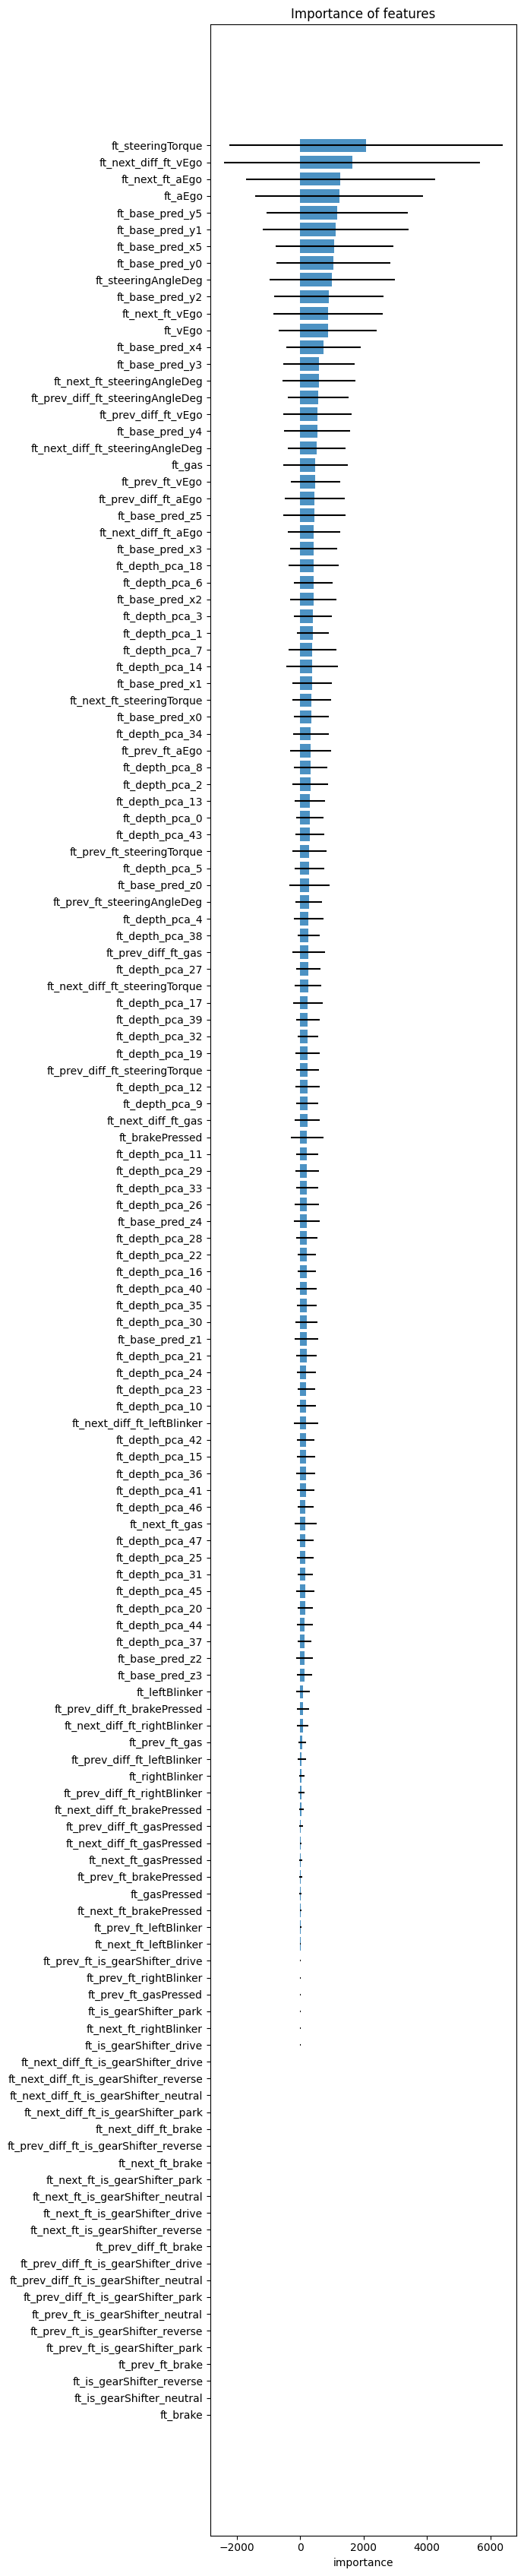

In [15]:
utils.plot_lgb_importance(
    sum([model.models for model in models], []), models[0].feature_names
)

In [16]:
oof_preds = oof_preds.select(pl.all().name.prefix("pred_"))
pred_cols = oof_preds.columns

tr_df = pl.concat([tr_df, oof_preds], how="horizontal")
tr_df

ID,vEgo,aEgo,steeringAngleDeg,steeringTorque,brake,brakePressed,gas,gasPressed,gearShifter,leftBlinker,rightBlinker,x_0,y_0,z_0,x_1,y_1,z_1,x_2,y_2,z_2,x_3,y_3,z_3,x_4,y_4,z_4,x_5,y_5,z_5,scene_id,scene_dsec,origin_idx,base_pred_x_0,base_pred_y_0,base_pred_z_0,base_pred_x_1,…,ft_depth_pca_47,ft_base_pred_x0,ft_base_pred_y0,ft_base_pred_z0,ft_base_pred_x1,ft_base_pred_y1,ft_base_pred_z1,ft_base_pred_x2,ft_base_pred_y2,ft_base_pred_z2,ft_base_pred_x3,ft_base_pred_y3,ft_base_pred_z3,ft_base_pred_x4,ft_base_pred_y4,ft_base_pred_z4,ft_base_pred_x5,ft_base_pred_y5,ft_base_pred_z5,pred_tg_cood_x_0,pred_tg_cood_y_0,pred_tg_cood_z_0,pred_tg_cood_x_1,pred_tg_cood_y_1,pred_tg_cood_z_1,pred_tg_cood_x_2,pred_tg_cood_y_2,pred_tg_cood_z_2,pred_tg_cood_x_3,pred_tg_cood_y_3,pred_tg_cood_z_3,pred_tg_cood_x_4,pred_tg_cood_y_4,pred_tg_cood_z_4,pred_tg_cood_x_5,pred_tg_cood_y_5,pred_tg_cood_z_5
str,f64,f64,f64,f64,f64,bool,f64,bool,str,bool,bool,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,i32,i64,f64,f64,f64,f64,…,f32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""00066be8e20318869c38c66be46663…",5.701526,1.538456,-2.165777,-139.0,0.0,false,0.25,true,"""drive""",false,false,0.183577,0.039504,0.040269,0.287741,0.101286,0.088225,0.237718,0.231447,0.149948,0.088703,0.382465,0.220581,0.151826,0.547122,0.284533,0.142148,0.775908,0.322716,"""00066be8e20318869c38c66be46663…",320,0,2.646014,-0.007278,0.004917,5.944259,…,1.462184,2.646014,-0.007278,0.004917,5.944259,-0.035391,0.019749,9.547291,-0.106475,0.053701,13.39677,-0.219017,0.082237,17.422401,-0.372834,0.121798,21.809121,-0.576405,0.162363,0.000247,0.005381,0.001284,0.030551,0.01598,0.004394,0.061669,0.018078,-0.00288,0.118143,0.0224,-0.00587,0.187845,0.00665,0.002122,0.237118,0.010995,-0.027377
"""00066be8e20318869c38c66be46663…",11.176292,0.279881,-11.625697,-44.0,0.0,false,0.0,false,"""drive""",false,true,-0.060647,0.046212,-0.005639,-0.229784,0.144813,-0.043455,-0.311511,0.483686,-0.028311,-0.328021,1.014553,-0.005062,-0.485779,1.757589,0.013329,-0.681698,2.789619,0.019083,"""00066be8e20318869c38c66be46663…",420,1,5.030914,-0.054149,0.010667,10.580273,…,1.18996,5.030914,-0.054149,0.010667,10.580273,-0.177187,0.022755,16.081566,-0.399613,0.036957,21.460436,-0.62321,0.041396,26.802268,-0.914465,0.051672,32.065512,-1.364549,0.054,0.000247,-0.002092,0.000127,-0.007769,-0.027746,0.001771,-0.024507,-0.052858,0.001439,-0.016932,-0.034851,-0.005077,-0.000944,-0.057714,-0.009451,0.003146,0.005674,-0.009177
"""00066be8e20318869c38c66be46663…",10.472548,0.231099,-2.985105,-132.0,0.0,false,0.18,true,"""drive""",false,false,0.083017,0.018232,0.016805,0.08774,0.046115,0.024384,0.004205,-0.002043,0.036224,-0.263779,-0.070232,0.051409,-0.57391,-0.106083,0.095295,-1.123516,-0.113971,0.154177,"""00066be8e20318869c38c66be46663…",520,2,4.732684,-0.019045,0.000773,10.065782,…,-3.12964,4.732684,-0.019045,0.000773,10.065782,-0.073915,0.001781,15.442334,-0.153944,0.004174,20.881939,-0.2867,0.007355,26.251297,-0.470902,0.007563,31.583548,-0.727924,-0.001288,0.000247,-0.0044,0.00022,0.011013,-0.013739,-0.000323,0.045544,-0.02556,-0.000232,0.080067,-0.062161,0.002828,0.089506,-0.125459,0.002884,0.11027,-0.222172,0.003441
"""000fb056f97572d384bae4f5fc1e0f…",3.316744,1.276733,-31.725477,-114.0,0.0,false,0.255,true,"""drive""",false,false,0.005318,0.010914,-0.010379,0.0299,0.04575,-0.021171,0.089006,0.052356,-0.03,0.257849,0.056075,-0.033059,0.306511,0.007129,-0.036153,0.379072,0.007994,-0.028834,"""000fb056f97572d384bae4f5fc1e0f…",20,4,1.546542,-0.052763,0.001532,3.645262,…,13.052367,1.546542,-0.052763,0.001532,3.645262,-0.170939,0.007445,6.024561,-0.291517,0.017113,8.512933,-0.437888,0.029161,11.312801,-0.561617,0.047546,14.277977,-0.786794,0.073077,0.000247,0.001588,0.000402,0.017832,0.011411,0.000553,0.073426,0.022492,-0.009393,0.133869,0.05947,-0.020271,0.229793,0.090072,-0.027029,0.280489,

## 評価

In [17]:
def calc_score(df: pl.DataFrame, pred_cols: list[str]):
    tg_cols = TARGET_COLS

    tg = df.select(tg_cols).to_numpy()
    pred = df.select(pred_cols).to_numpy()

    scores = np.abs(tg - pred).mean(axis=0)
    scores = {f"score_{col}": float(score) for col, score in zip(pred_cols, scores)}
    scores["avg"] = float(np.abs(tg - pred).mean())
    return scores


scores = calc_score(tr_df, pred_cols)
scores

{'score_pred_tg_cood_x_0': 0.06046829298471465,
 'score_pred_tg_cood_y_0': 0.03413497349064057,
 'score_pred_tg_cood_z_0': 0.025876029972811063,
 'score_pred_tg_cood_x_1': 0.12978352690772477,
 'score_pred_tg_cood_y_1': 0.07672057990840286,
 'score_pred_tg_cood_z_1': 0.05369563602454444,
 'score_pred_tg_cood_x_2': 0.22301437177059835,
 'score_pred_tg_cood_y_2': 0.13732213168981106,
 'score_pred_tg_cood_z_2': 0.08239235841454773,
 'score_pred_tg_cood_x_3': 0.35011595472950713,
 'score_pred_tg_cood_y_3': 0.2270307950695634,
 'score_pred_tg_cood_z_3': 0.11214570742390431,
 'score_pred_tg_cood_x_4': 0.5106222722455094,
 'score_pred_tg_cood_y_4': 0.35155108027984705,
 'score_pred_tg_cood_z_4': 0.14249350204058173,
 'score_pred_tg_cood_x_5': 0.6953361905160784,
 'score_pred_tg_cood_y_5': 0.5104616636487145,
 'score_pred_tg_cood_z_5': 0.17370123346967278,
 'avg': 0.21649257225484297}

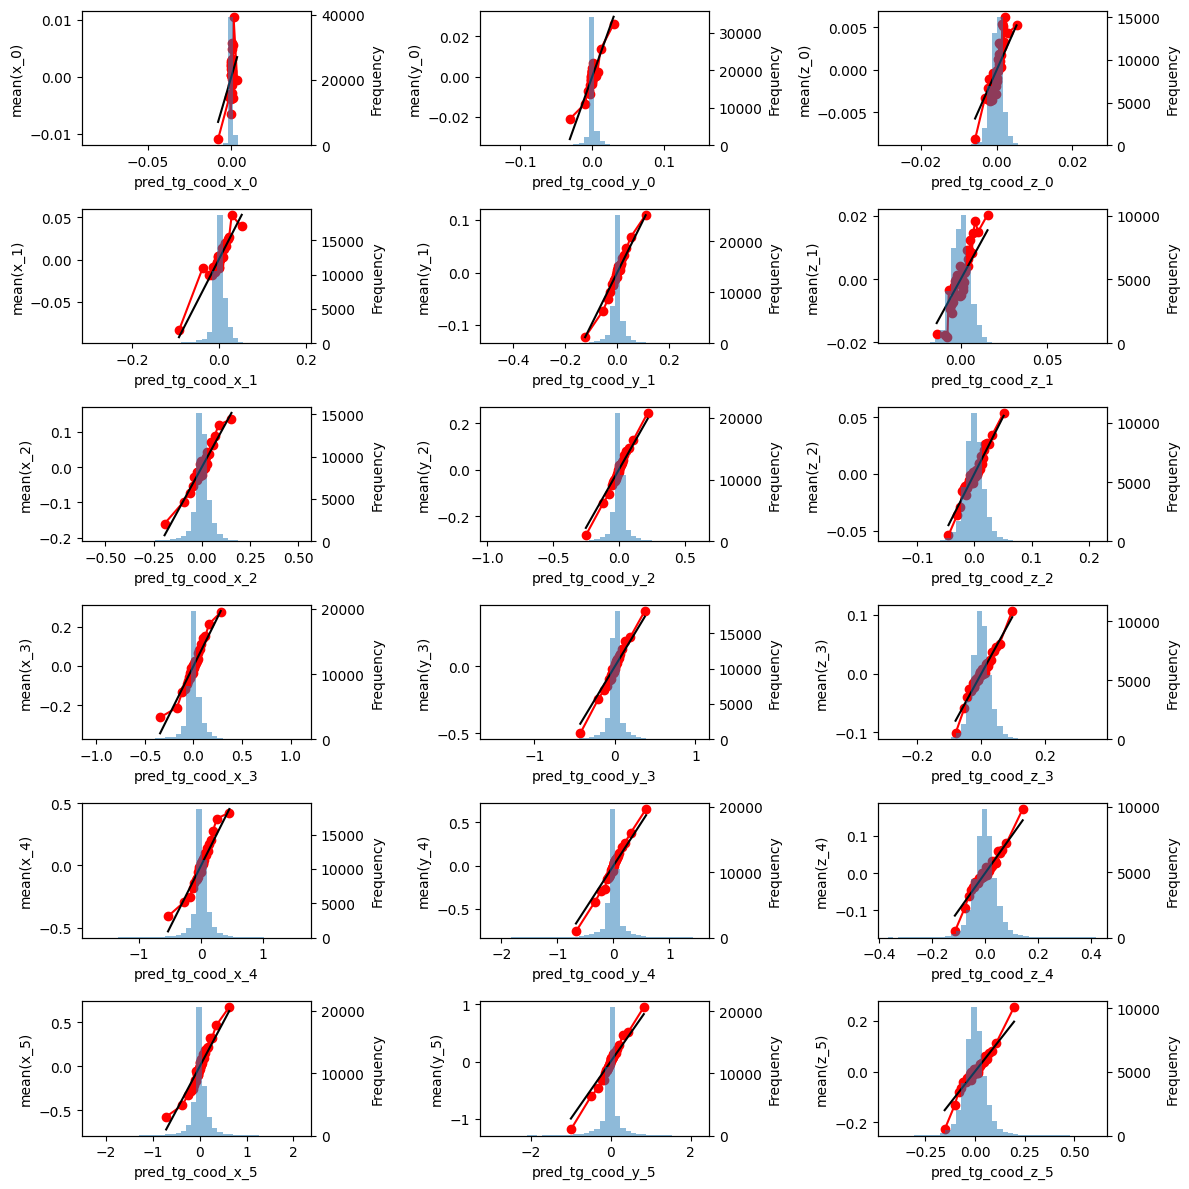

In [18]:
utils.plot_calibration_curve(tr_df, pred_cols, n_bins=40)

In [19]:
if BASE_PRED_DIR is not None:
    # 差し引いていた基礎推定値を足して元のtarget, pred列に戻す
    tr_df = add_base_pred_to_target(tr_df, TARGET_COLS)
    tr_df = add_base_pred_to_target(tr_df, pred_cols)

In [20]:
if BASE_PRED_DIR is not None:
    scores = calc_score(tr_df, pred_cols)
    display(scores)

{'score_pred_tg_cood_x_0': 0.06046829298471466,
 'score_pred_tg_cood_y_0': 0.03413497349064057,
 'score_pred_tg_cood_z_0': 0.025876029972811063,
 'score_pred_tg_cood_x_1': 0.1297835269077248,
 'score_pred_tg_cood_y_1': 0.07672057990840286,
 'score_pred_tg_cood_z_1': 0.05369563602454444,
 'score_pred_tg_cood_x_2': 0.2230143717705983,
 'score_pred_tg_cood_y_2': 0.13732213168981106,
 'score_pred_tg_cood_z_2': 0.08239235841454773,
 'score_pred_tg_cood_x_3': 0.3501159547295072,
 'score_pred_tg_cood_y_3': 0.2270307950695634,
 'score_pred_tg_cood_z_3': 0.11214570742390431,
 'score_pred_tg_cood_x_4': 0.5106222722455094,
 'score_pred_tg_cood_y_4': 0.35155108027984705,
 'score_pred_tg_cood_z_4': 0.14249350204058173,
 'score_pred_tg_cood_x_5': 0.6953361905160784,
 'score_pred_tg_cood_y_5': 0.5104616636487145,
 'score_pred_tg_cood_z_5': 0.17370123346967276,
 'avg': 0.21649257225484297}

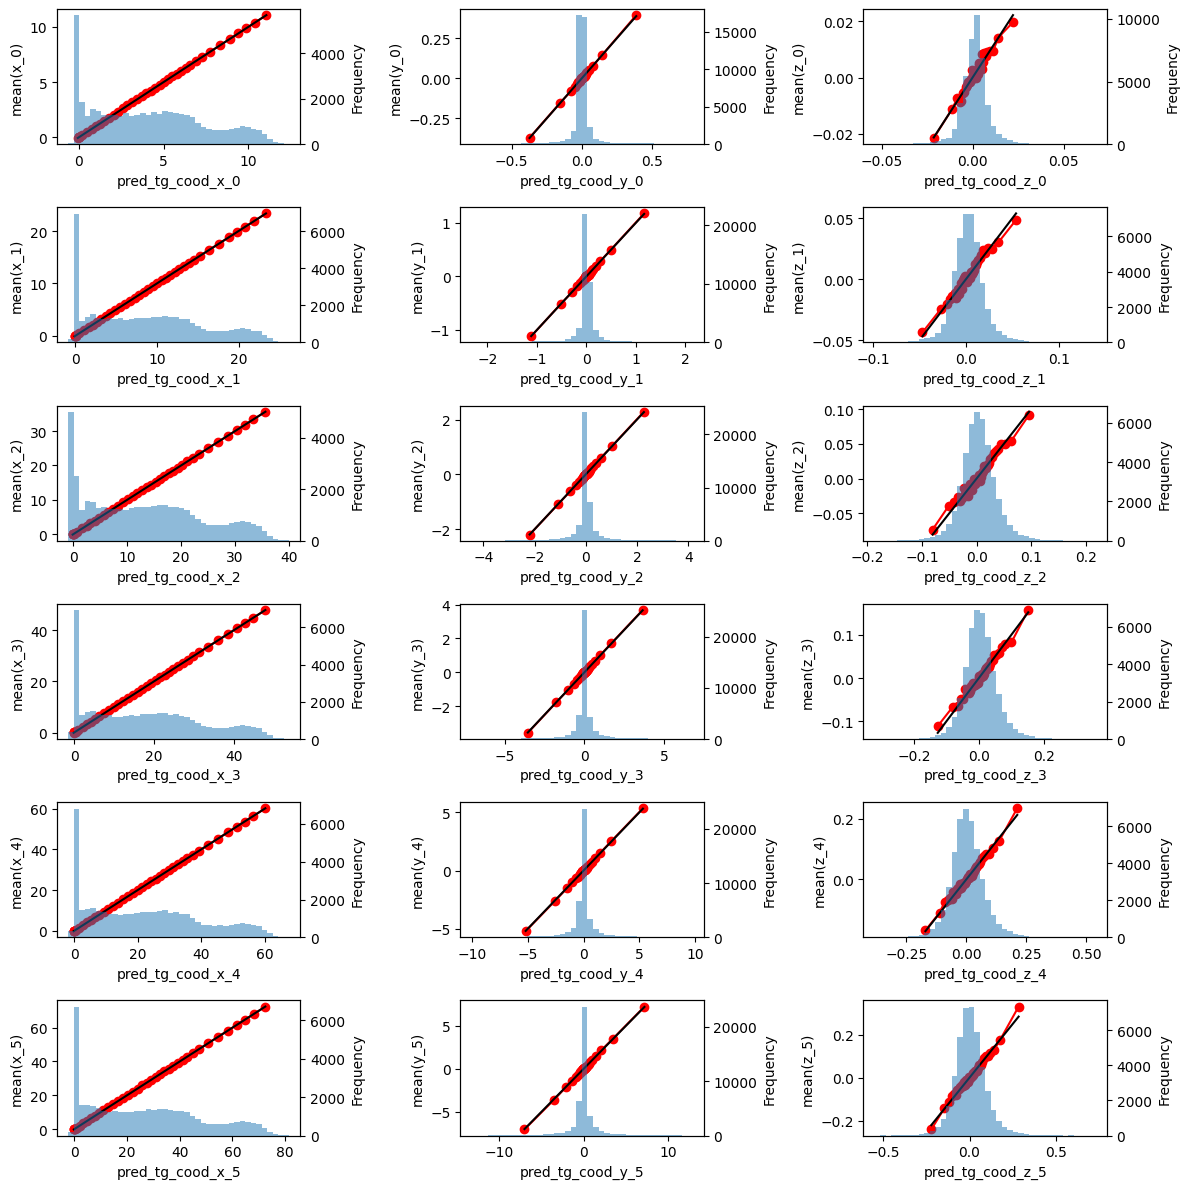

In [21]:
if BASE_PRED_DIR is not None:
    utils.plot_calibration_curve(tr_df, pred_cols, n_bins=40)

## oofを保存

In [22]:
def create_submission_csv(preds: pl.DataFrame, filename: str = "submission.csv"):
    submission_cols = TARGET_COLS

    # validate preds columns
    if len(preds.columns) != len(submission_cols):
        raise ValueError(
            f"preds columns must be {len(submission_cols)}, but got {len(preds.columns)}"
        )

    preds.columns = submission_cols
    preds.write_csv(filename)
    print(f"Submission file is created: {filename}")


# 元の順番に戻して保存
create_submission_csv(tr_df.sort("origin_idx").select(pred_cols), "oof_preds.csv")

Submission file is created: oof_preds.csv


## Submission

In [23]:
preds = utils.predict(
    models,
    ts_df,
    feature.columns,
    pred_cols=pred_cols,
)
pred_cols = preds.columns
ts_df = pl.concat([ts_df, preds], how="horizontal")

preds

pred_tg_cood_x_0,pred_tg_cood_y_0,pred_tg_cood_z_0,pred_tg_cood_x_1,pred_tg_cood_y_1,pred_tg_cood_z_1,pred_tg_cood_x_2,pred_tg_cood_y_2,pred_tg_cood_z_2,pred_tg_cood_x_3,pred_tg_cood_y_3,pred_tg_cood_z_3,pred_tg_cood_x_4,pred_tg_cood_y_4,pred_tg_cood_z_4,pred_tg_cood_x_5,pred_tg_cood_y_5,pred_tg_cood_z_5
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0.00029,0.007816,0.000987,0.024084,0.021405,0.002227,0.033475,0.038549,0.000104,0.069436,0.072213,-0.00657,0.091772,0.090386,-0.004703,0.069577,0.139762,-0.017473
0.000406,-0.011382,0.004043,-0.02607,-0.05035,0.010766,-0.045977,-0.138513,0.026211,-0.027775,-0.200652,0.040697,0.025733,-0.264331,0.054662,-0.032338,-0.313036,0.075108
0.000776,0.002429,0.000236,0.036609,-0.005296,-0.000868,0.071362,-0.00932,-0.009424,0.112647,-0.021435,-0.019615,0.18288,-0.071816,-0.026603,0.256536,-0.117997,-0.030338
0.000064,-0.006015,0.002426,0.004554,-0.043965,0.005412,-0.007796,-0.130766,0.001755,-0.022742,-0.163936,-0.000251,-0.026177,-0.238788,0.012809,-0.109702,-0.372466,0.011405
0.000875,0.000236,-0.000373,0.000616,-0.00668,-0.001463,0.010593,-0.010364,-0.005063,0.021543,-0.020829,0.00021,-0.009092,-0.036287,-0.003804,-0.113791,-0.048078,-0.000351
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
0.000223,-0.000903,0.001179,-0.002715,-0.009576,0.003983,-0.022479,-0.030948,0.00955,-0.046734,-0.058604,0.006576,-0.061843,-0.088331,-0.001293,-0.080052,-0.135863,0.00784
0.000088,-0.00111,-0.00226,0.006491,-0.004583,-0.009649,0.034175,-0.006823,-0.049261,0.043892,-0.014449,-0.103385,0.064716,-0.041544,-0.168594,0.050664,-0.040744,-0.237583
-0.000181,-0.003054,0.001057,-0.007261,-0.017195,0.005226,-0.02238,-0.035403,0.016939,-0.036894,-0.063078,0.030912,-0.056561,-0.108414,0.047486,-0.075056,-0.162977,0.072641


In [24]:
if BASE_PRED_DIR is not None:
    # 差し引いていた基礎推定値を足して元のtarget, pred列に戻す
    ts_df = add_base_pred_to_target(ts_df, pred_cols)
    display(ts_df)

ID,vEgo,aEgo,steeringAngleDeg,steeringTorque,brake,brakePressed,gas,gasPressed,gearShifter,leftBlinker,rightBlinker,scene_id,scene_dsec,origin_idx,base_pred_x_0,base_pred_y_0,base_pred_z_0,base_pred_x_1,base_pred_y_1,base_pred_z_1,base_pred_x_2,base_pred_y_2,base_pred_z_2,base_pred_x_3,base_pred_y_3,base_pred_z_3,base_pred_x_4,base_pred_y_4,base_pred_z_4,base_pred_x_5,base_pred_y_5,base_pred_z_5,ft_vEgo,ft_aEgo,ft_steeringAngleDeg,ft_steeringTorque,…,ft_depth_pca_47,ft_base_pred_x0,ft_base_pred_y0,ft_base_pred_z0,ft_base_pred_x1,ft_base_pred_y1,ft_base_pred_z1,ft_base_pred_x2,ft_base_pred_y2,ft_base_pred_z2,ft_base_pred_x3,ft_base_pred_y3,ft_base_pred_z3,ft_base_pred_x4,ft_base_pred_y4,ft_base_pred_z4,ft_base_pred_x5,ft_base_pred_y5,ft_base_pred_z5,pred_tg_cood_x_0,pred_tg_cood_y_0,pred_tg_cood_z_0,pred_tg_cood_x_1,pred_tg_cood_y_1,pred_tg_cood_z_1,pred_tg_cood_x_2,pred_tg_cood_y_2,pred_tg_cood_z_2,pred_tg_cood_x_3,pred_tg_cood_y_3,pred_tg_cood_z_3,pred_tg_cood_x_4,pred_tg_cood_y_4,pred_tg_cood_z_4,pred_tg_cood_x_5,pred_tg_cood_y_5,pred_tg_cood_z_5
str,f64,f64,f64,f64,f64,bool,f64,bool,str,bool,bool,str,i32,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""012baccc145d400c896cb82065a93d…",3.374273,-0.01936,-34.008415,17.0,0.0,false,0.0,false,"""drive""",false,false,"""012baccc145d400c896cb82065a93d…",120,0,1.490734,-0.064386,0.000439,3.115229,-0.158864,-0.000535,4.706965,-0.244142,-0.003911,6.26155,-0.34182,-0.009575,7.768367,-0.408649,-0.009912,9.210334,-0.503614,-0.010509,3.374273,-0.01936,-34.008415,17.0,…,5.745213,1.490734,-0.064386,0.000439,3.115229,-0.158864,-0.000535,4.706965,-0.244142,-0.003911,6.26155,-0.34182,-0.009575,7.768367,-0.408649,-0.009912,9.210334,-0.503614,-0.010509,1.491025,-0.056569,0.001426,3.139313,-0.13746,0.001691,4.74044,-0.205593,-0.003807,6.330986,-0.269607,-0.016145,7.860138,-0.318263,-0.014616,9.279911,-0.363853,-0.027982
"""012baccc145d400c896cb82065a93d…",2.441048,-0.022754,307.860077,295.0,0.0,true,0.0,false,"""drive""",false,false,"""012baccc145d400c896cb82065a93d…",220,1,0.956104,0.417954,-0.002337,1.904383,1.045392,-0.00357,2.741796,1.81237,-0.009285,3.435321,2.572323,-0.005621,4.100868,3.466124,0.000878,4.89148,4.533245,0.010369,2.441048,-0.022754,307.860077,295.0,…,2.870487,0.956104,0.417954,-0.002337,1.904383,1.045392,-0.00357,2.741796,1.81237,-0.009285,3.435321,2.572323,-0.005621,4.100868,3.466124,0.000878,4.89148,4.533245,0.010369,0.95651,0.406572,0.001706,1.878312,0.995042,0.007196,2.695819,1.673857,0.016926,3.407545,2.371671,0.035077,4.126601,3.201793,0.05554,4.859142,4.220208,0.085477
"""012baccc145d400c896cb82065a93d…",3.604152,-0.286239,10.774388,-110.0,0.0,true,0.0,false,"""drive""",false,false,"""012baccc145d400c896cb82065a93d…",320,2,1.587646,0.022718,-0.00015,3.279845,0.050072,-0.001164,4.800466,0.102129,-0.002604,6.238437,0.143173,-0.001218,7.5763,0.19575,-0.000716,8.869421,0.255478,-0.00398,3.604152,-0.286239,10.774388,-110.0,…,1.480733,1.587646,0.022718,-0.00015,3.279845,0.050072,-0.001164,4.800466,0.102129,-0.002604,6.238437,0.143173,-0.001218,7.5763,0.19575,-0.000716,8.869421,0.255478,-0.00398,1.588421,0.025147,0.000086,3.316454,0.044776,-0.002032,4.871829,0.092808,-0.012028,6.351084,0.121738,-0.020833,7.75918,0.123935,-0.02732,9.125957,0.137481,-0.034319
"""012baccc145d400c896cb82065a93d…",2.048902,-0.537628,61.045235,189.0,0.0,true,0.0,false,"""drive""",true,false,"""012baccc145d400c896cb82065a93d…",420,3,0.857239,0.075623,-0.006414,1.684752,0.252421,-0.014388,2.382249,0.470947,-0.022364,2.95191,0.887097,-0.031396,3.420963,1.550305,-0.039175,3.864955,2.443597,-0.050181,2.048902,-0.537628,61.045235,189.0,…,-1.432227,0.857239,0.075623,-0.006414,1.684752,0.252421,-0.014388,2.382249,0.470947,-0.022364,2.95191,0.887097,-0.031396,3.420963,1.550305,-0.039175,3.864955,2.443597,-0.050181

In [25]:
# 元の順番に戻す
ts_df = ts_df.sort("origin_idx")

In [26]:
create_submission_csv(ts_df.select(pred_cols), "submission.csv")

Submission file is created: submission.csv
